# Analysis of key generation data

In [1]:
%matplotlib notebook
import numpy as np
from scipy.stats import describe
from scipy.stats import norm as norm_dist
from scipy.stats.mstats import mquantiles
from math import log, sqrt
import matplotlib.pyplot as plt
from matplotlib import ticker, colors, gridspec
from copy import deepcopy
from utils import plot_hist, moving_average, hw, time_scale
from binascii import unhexlify
from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import tabulate

## Settings
Enter your input below.

In [2]:
# File name with output from ECTesterReader or ECTesterStandalone key generation.
fname = "keys.csv"

# The time unit used in displaying the plots. One of "milli", "micro", "nano".
# WARNING: Using nano might lead to very large plots/histograms and to the
#          notebook to freeze or run out of memory, as well as bad visualization
#          quality, due to noise and low density.
gen_unit = "micro" # Unit of key generation command
export_unit = "micro" # Unit of key export command
# A number which will be used to divide the time into sub-units, e.g. for 5, time will be in fifths of units
scaling_factor = 1

# The amount of entries skipped from the beginning of the file, as they are usually outliers.
skip_first = 10

# Whether to plot things in logarithmic scale or not.
log_scale = False

# Whether to trim the time data outside the 1 - 99 percentile range (adjust below). Quite useful.
trim = True

# How much to trim? Either a number in [0,1] signifying a quantile, or an absolute value signifying a threshold
trim_low = 0.01
trim_high = 0.99

# Graphical (matplotlib) style name
style = "ggplot"

# Color map to use, and what color to assign to "bad" values (necessary for log_scale)
color_map = plt.cm.viridis
color_map_bad = "black"

# What function to use to calculate number of histogram bins of time
# one of "sqrt", "sturges", "rice", "scott" and "fd" or a number specifying the number of bins
hist_size = "sturges"

## Data processing

In [3]:
# Setup plot style

plt.style.use(style)

cmap = deepcopy(color_map)
cmap.set_bad(color_map_bad)

# Normalization, linear or log.
if log_scale:
    norm = colors.LogNorm()
else:
    norm = colors.Normalize()

# Read the header line.

with open(fname, "r") as f:
    header = f.readline()
header_names = header.split(";")
if len(header_names) not in (4, 5):
    print("Bad data?")
    exit(1)

# Load the data

hx = lambda x: int(x, 16)
if len(header_names) == 4:
    data = np.genfromtxt(fname, delimiter=";", skip_header=1, converters={2: unhexlify, 3: hx},
                         dtype=np.dtype([("index", "u4"), ("gen_time", "u4"), ("pub", "O"), ("priv", "O")]))
else:
    data = np.genfromtxt(fname, delimiter=";", skip_header=1, converters={3: unhexlify, 4: hx},
                         dtype=np.dtype([("index", "u4"), ("gen_time", "u4"), ("export_time", "u4"),
                                         ("pub", "O"), ("priv", "O")]))

# Skip first (outliers?)

data = data[skip_first:]

# Setup the data

# Convert time data
orig_gen_unit = header_names[1].split("[")[1][:-1]
gen_disp_unit = time_scale(data["gen_time"], orig_gen_unit, gen_unit, scaling_factor)
if len(header_names) == 5:
    orig_export_unit = header_names[2].split("[")[1][:-1]
    export_disp_unit = time_scale(data["export_time"], orig_export_unit, export_unit, scaling_factor)

# Trim gen times
quant_low_bound = trim_low if 0 <= trim_low <= 1 else 0.01
quant_high_bound = trim_high if 0 <= trim_high <= 1 else 0.95
quantiles_gen = mquantiles(data["gen_time"], prob=(quant_low_bound, 0.25, 0.5, 0.75, quant_high_bound))
if trim:
    low_bound = quantiles_gen[0] if 0 <= trim_low <= 1 else trim_low
    high_bound = quantiles_gen[4] if 0 <= trim_high <= 1 else trim_high
    data_trimmed = data[np.logical_and(data["gen_time"] >= low_bound,
                                       data["gen_time"] <= high_bound)]
    quantiles_gen_trim = mquantiles(data_trimmed["gen_time"], prob=(quant_low_bound, 0.25, 0.5, 0.75, quant_high_bound))
else:
    low_bound = None
    high_bound = None
    data_trimmed = data
    quantiles_gen_trim = quantiles_gen

description_gen = describe(data["gen_time"])
description_gen_trim = describe(data_trimmed["gen_time"])

max_gen_time = description_gen.minmax[1]
min_gen_time = description_gen.minmax[0]
bit_size = len(bin(max(data["priv"]))) - 2
byte_size = (bit_size + 7) // 8
bit_size = byte_size * 8

if hist_size == "sqrt":
    hist_size_func = lambda n, xmin, xmax, var, xlower, xupper: int(sqrt(n)) + 1
elif hist_size == "sturges":
    hist_size_func = lambda n, xmin, xmax, var, xlower, xupper: int(log(n, 2)) + 1
elif hist_size == "rice":
    hist_size_func = lambda n, xmin, xmax, var, xlower, xupper: int(2 * n**(1/3))
elif hist_size == "scott":
    hist_size_func = lambda n, xmin, xmax, var, xlower, xupper: (xmax - xmin) // int((3.5 * sqrt(var)) / (n**(1/3)))
elif hist_size == "fd":
    hist_size_func = lambda n, xmin, xmax, var, xlower, xupper: (xmax - xmin) // int(2 * (xupper - xlower) / (n**(1/3)))
else:
    hist_size_func = lambda n, xmin, xmax, var, xlower, xupper: hist_size

hist_size_gen_time = hist_size_func(description_gen.nobs, min_gen_time, max_gen_time, description_gen.variance, quantiles_gen[1], quantiles_gen[3])
hist_size_gen_time_trim = hist_size_func(description_gen_trim.nobs, description_gen_trim.minmax[0], description_gen_trim.minmax[1], description_gen_trim.variance, quantiles_gen_trim[1], quantiles_gen_trim[3])

if hist_size_gen_time < 30:
    hist_size_gen_time = max_gen_time - min_gen_time
if hist_size_gen_time_trim < 30:
    hist_size_gen_time_trim = description_gen_trim.minmax[1] - description_gen_trim.minmax[0]

## Analysis

### Summary

In [4]:
display("Raw")
desc = [("N", "min, max", "mean", "variance", "skewness", "kurtosis"),
        description_gen]
display(HTML(tabulate.tabulate(desc, tablefmt="html")))
display("Trimmed")
desc = [("N", "min, max", "mean", "variance", "skewness", "kurtosis"),
        description_gen_trim]
display(HTML(tabulate.tabulate(desc, tablefmt="html")))

'Raw'

N,"min, max",mean,variance,skewness,kurtosis
499990,"(58, 209)",59.70197803956079,18.851927429841197,11.083469288472967,147.5736861692563


'Trimmed'

N,"min, max",mean,variance,skewness,kurtosis
495305,"(59, 79)",59.33118987290659,1.9173550248905773,9.478442570685667,109.67008597996794


### Selected quantiles

In [5]:
tbl = [(quant_low_bound, "0.25", "0.5", "0.75", quant_high_bound),
       list(map(lambda x: "{} {}".format(x, gen_disp_unit), quantiles_gen))]
display(HTML(tabulate.tabulate(tbl, tablefmt="html")))

0.01,0.25,0.5,0.75,0.99
59.0 $\mu s$,59.0 $\mu s$,59.0 $\mu s$,59.0 $\mu s$,79.0 $\mu s$


### Info

In [6]:
display("Bitsize:", bit_size)
display("Histogram time bins: {}".format(hist_size_gen_time))
display("Histogram time bins(trimmed): {}".format(hist_size_gen_time_trim))

'Bitsize:'

256

'Histogram time bins: 151'

'Histogram time bins(trimmed): 20'

## Plots

### Private key MSB vs time heatmap
The heatmap should show uncorrelated variables.

<IPython.core.display.Javascript object>


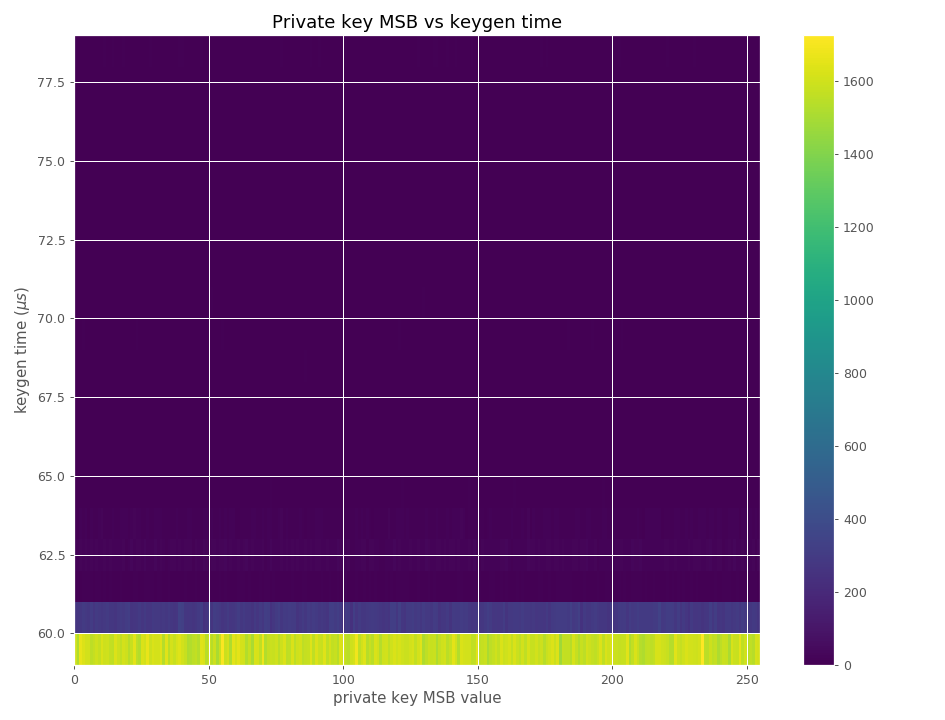

In [7]:
fig_private = plt.figure(figsize=(10.5, 8), dpi=90)
axe_private = fig_private.add_subplot(1, 1, 1, title="Private key MSB vs keygen time")
priv_msb = np.array(list(map(lambda x: x >> (bit_size - 8), data_trimmed["priv"])), dtype=np.dtype("u1"))
max_msb = max(priv_msb)
min_msb = min(priv_msb)
heatmap, xedges, yedges = np.histogram2d(priv_msb, data_trimmed["gen_time"],
                                         bins=[max_msb - min_msb + 1, hist_size_gen_time_trim])
extent = [min_msb, max_msb, yedges[0], yedges[-1]]
im = axe_private.imshow(heatmap.T, extent=extent, aspect="auto", cmap=cmap, origin="low",
                   interpolation="nearest", norm=norm)
axe_private.set_xlabel("private key MSB value")
axe_private.set_ylabel("keygen time ({})".format(gen_disp_unit))
fig_private.colorbar(im, ax=axe_private)

fig_private.tight_layout()
del priv_msb

### Private key Hamming Weight vs time heatmap
The heatmap should show uncorrelated variables.

Also contains a private key Hamming Weight histogram, which should be binomially distributed.

<IPython.core.display.Javascript object>


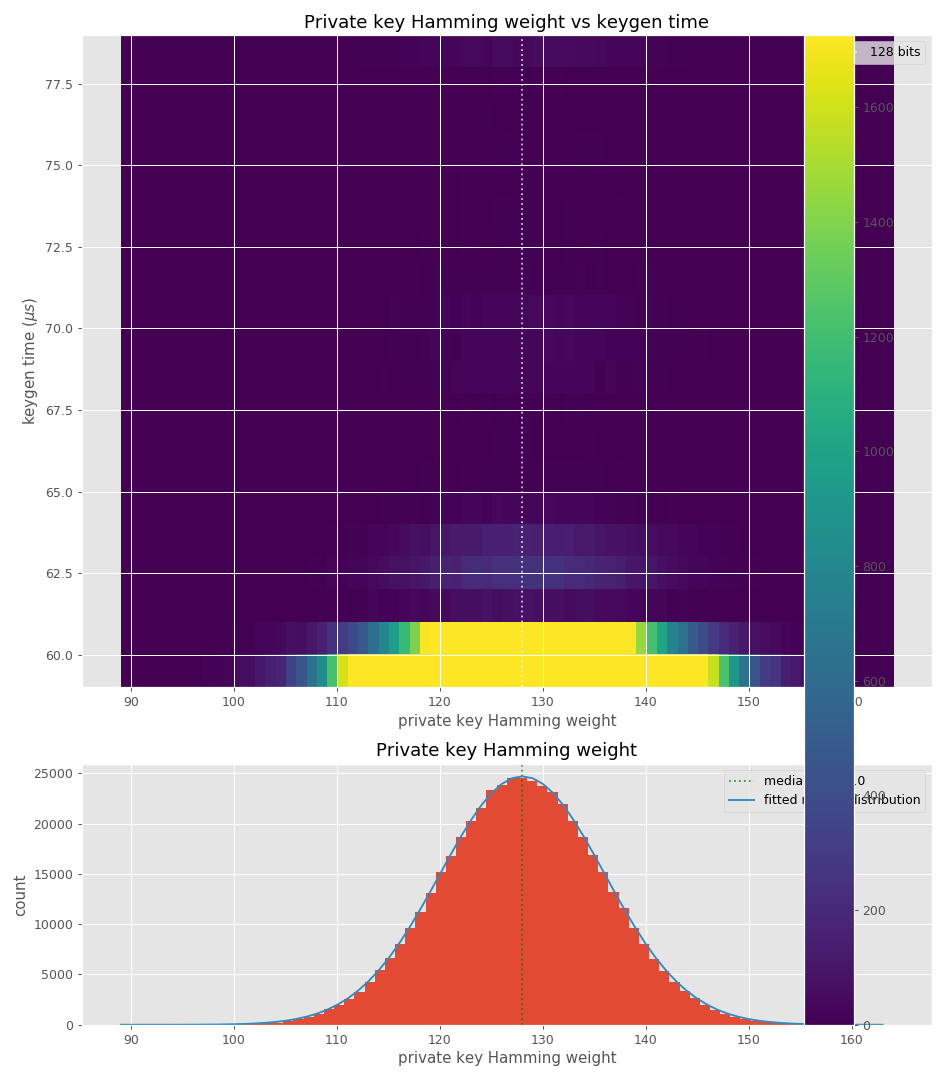

Mean,Variance
128.00736112092548,8.002344318051815


In [8]:
fig_priv_hist = plt.figure(figsize=(10.5, 12), dpi=90)
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1])
axe_priv_hist = fig_priv_hist.add_subplot(gs[0], title="Private key Hamming weight vs keygen time")
axe_priv_hist_hw = fig_priv_hist.add_subplot(gs[1], sharex=axe_priv_hist, title="Private key Hamming weight")
priv_hw = np.array(list(map(hw, data_trimmed["priv"])), dtype=np.dtype("u2"))
h, xe, ye = np.histogram2d(priv_hw, data_trimmed["gen_time"], bins=[max(priv_hw) - min(priv_hw), hist_size_gen_time_trim])
im = axe_priv_hist.imshow(h.T, origin="low", cmap=cmap, aspect="auto", extent=[xe[0], xe[-1], ye[0], ye[-1]], norm=norm)
axe_priv_hist.axvline(x=bit_size//2, alpha=0.7, linestyle="dotted", color="white", label=str(bit_size//2) + " bits")
axe_priv_hist.set_xlabel("private key Hamming weight")
axe_priv_hist.set_ylabel("keygen time ({})".format(gen_disp_unit))
axe_priv_hist.legend(loc="best")

plot_hist(axe_priv_hist_hw, priv_hw, "private key Hamming weight", log_scale, None)

param = norm_dist.fit(priv_hw)
pdf_range = np.arange(min(priv_hw), max(priv_hw))
norm_pdf = norm_dist.pdf(pdf_range, *param[:-2], loc=param[-2], scale=param[-1]) * description_gen_trim.nobs
axe_priv_hist_hw.plot(pdf_range, norm_pdf, label="fitted normal distribution")
axe_priv_hist_hw.legend(loc="best")


display(HTML("<b>Private key Hamming weight fitted with normal distribution:</b>"))
display(HTML(tabulate.tabulate([("Mean", "Variance"), param], tablefmt="html")))

fig_priv_hist.tight_layout()
fig_priv_hist.colorbar(im, ax=[axe_priv_hist, axe_priv_hist_hw])
del priv_hw

### Key generation time histogram

<IPython.core.display.Javascript object>


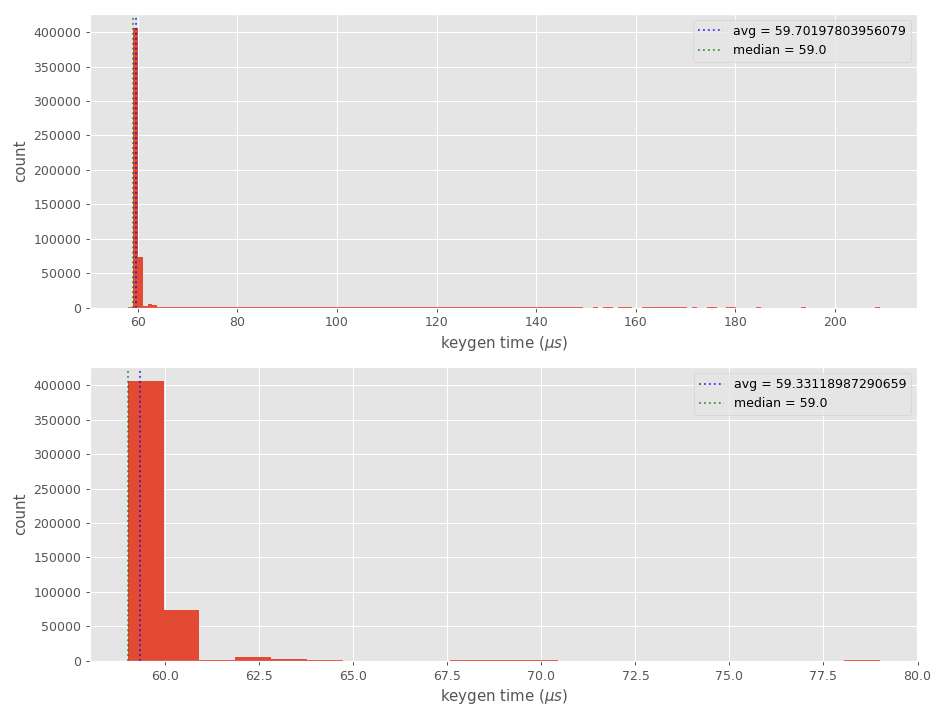

In [9]:
fig_kg_hist = plt.figure(figsize=(10.5, 8), dpi=90)
axe_hist_full = fig_kg_hist.add_subplot(2, 1, 1)
axe_hist_trim = fig_kg_hist.add_subplot(2, 1, 2)
plot_hist(axe_hist_full, data["gen_time"], "keygen time ({})".format(gen_disp_unit), log_scale, hist_size_gen_time);
plot_hist(axe_hist_trim, data_trimmed["gen_time"], "keygen time ({})".format(gen_disp_unit), log_scale, hist_size_gen_time_trim);
fig_kg_hist.tight_layout()

### Key export time histogram
*Available only for ECTesterReader and keys generated on cards.*

In [11]:
if "export_time" in data.dtype.names:
    fig_exp_hist = plt.figure(figsize=(10.5, 8), dpi=90)
    axe_hist_full = fig_exp_hist.add_subplot(2, 1, 1)
    axe_hist_trim = fig_exp_hist.add_subplot(2, 1, 2)
    plot_hist(axe_hist_full, data["export_time"], "export time ({})".format(export_disp_unit), log_scale, hist_size_gen_time);
    plot_hist(axe_hist_trim, data_trimmed["export_time"], "export time ({})".format(export_disp_unit), log_scale, hist_size_gen_time_trim);
    fig_exp_hist.tight_layout()

### Moving averages of key generation time

<IPython.core.display.Javascript object>


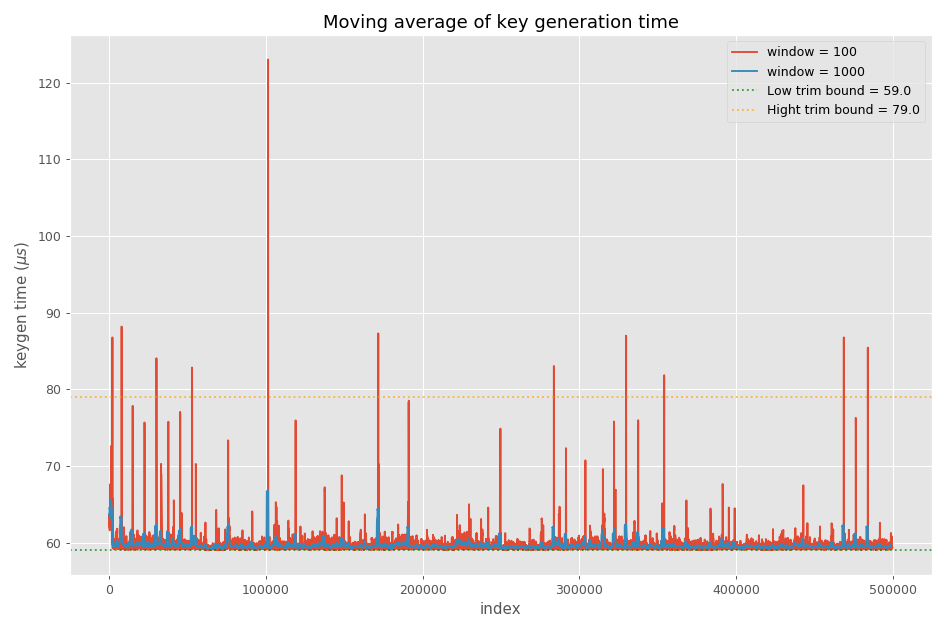

In [12]:
fig_avg = plt.figure(figsize=(10.5, 7), dpi=90)
axe_avg = fig_avg.add_subplot(1, 1, 1, title="Moving average of key generation time")
avg_100 = moving_average(data["gen_time"], 100)
avg_1000 = moving_average(data["gen_time"], 1000)
axe_avg.plot(avg_100, label="window = 100")
axe_avg.plot(avg_1000, label="window = 1000")
if low_bound is not None:
    axe_avg.axhline(y=low_bound, alpha=0.7, linestyle="dotted", color="green", label="Low trim bound = {}".format(low_bound))
if high_bound is not None:
    axe_avg.axhline(y=high_bound, alpha=0.7, linestyle="dotted", color="orange", label="Hight trim bound = {}".format(high_bound))
axe_avg.set_ylabel("keygen time ({})".format(gen_disp_unit))
axe_avg.set_xlabel("index")
axe_avg.legend(loc="best")

fig_avg.tight_layout()
del avg_100, avg_1000

### Private key MSB and LSB histograms
Expected to be uniform over [0, 255].

<IPython.core.display.Javascript object>


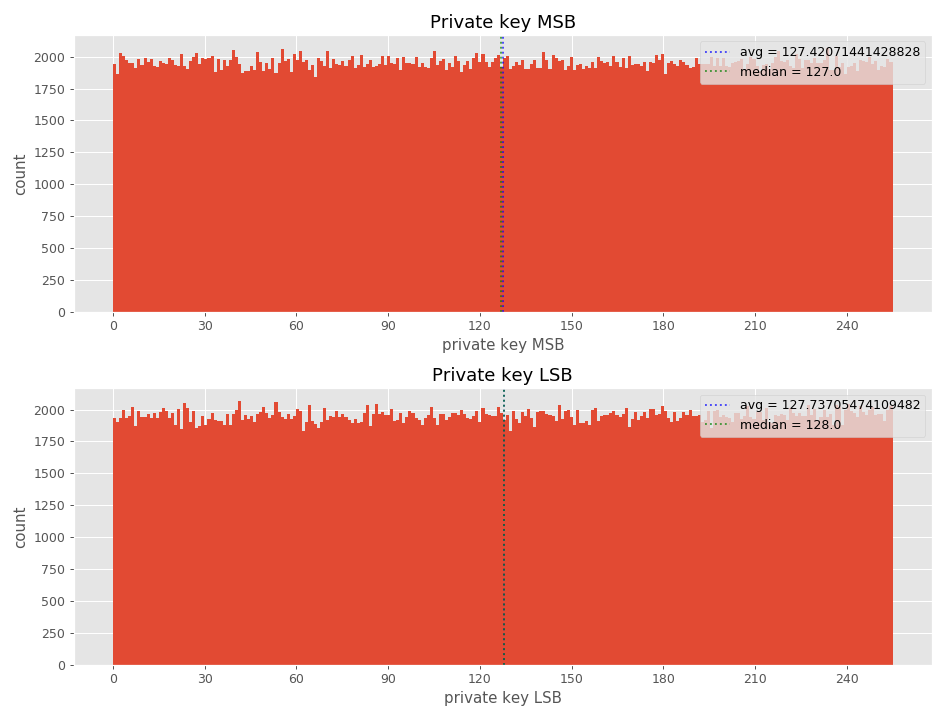

In [13]:
fig_priv_hists = plt.figure(figsize=(10.5, 8), dpi=90)
priv_msb = np.array(list(map(lambda x: x >> (bit_size - 8), data["priv"])), dtype=np.dtype("u1"))
priv_lsb = np.array(list(map(lambda x: x & 0xff, data["priv"])), dtype=np.dtype("u1"))
axe_msb_s_hist = fig_priv_hists.add_subplot(2, 1, 1, title="Private key MSB")
axe_lsb_s_hist = fig_priv_hists.add_subplot(2, 1, 2, title="Private key LSB")
plot_hist(axe_msb_s_hist, priv_msb, "private key MSB", log_scale)
plot_hist(axe_lsb_s_hist, priv_lsb, "private key LSB", log_scale)

fig_priv_hists.tight_layout()
del priv_msb, priv_lsb

### Public key coordinate MSB and LSB histograms
Expected to be somewhat uniform over [0, 255].

<IPython.core.display.Javascript object>


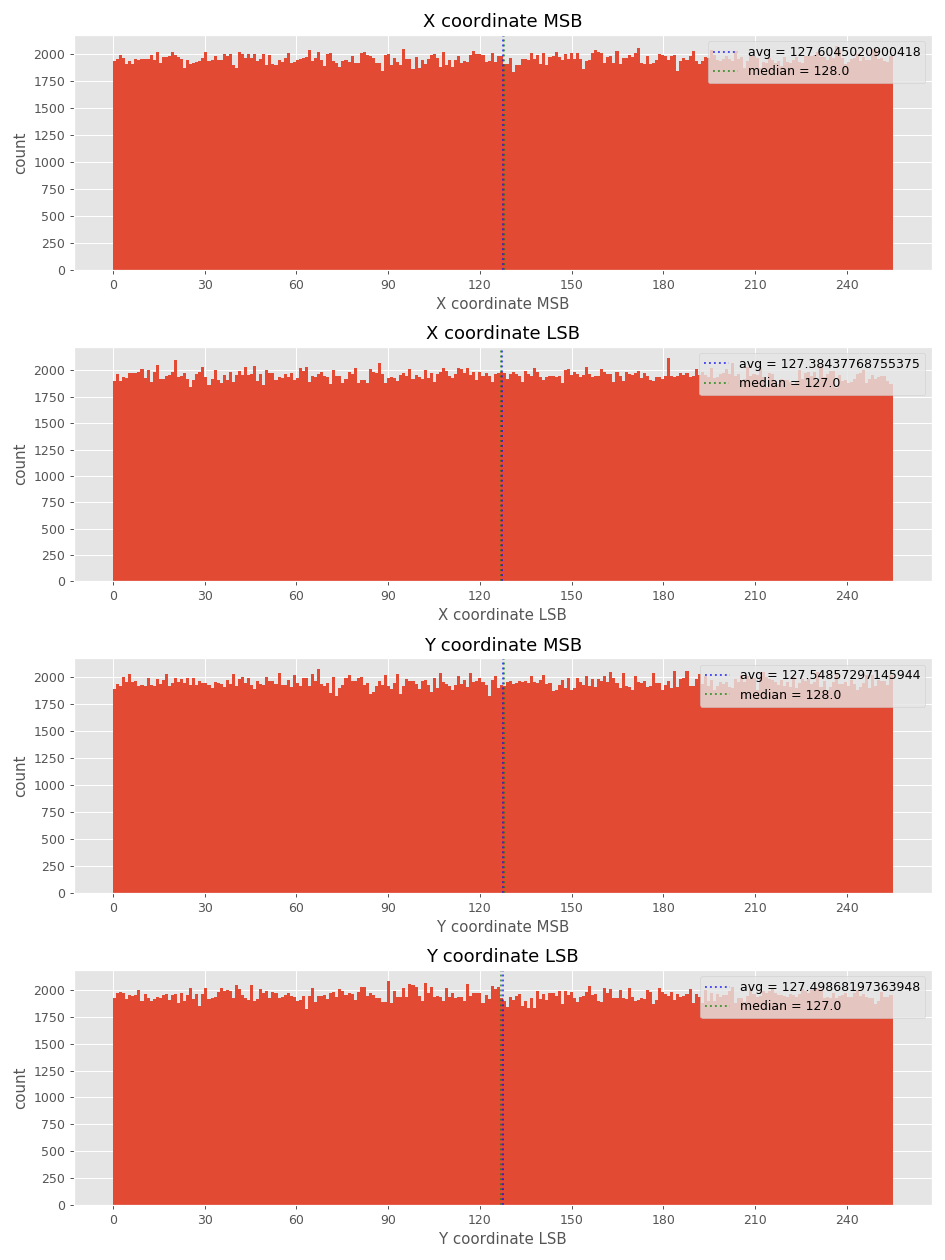

In [14]:
def _split(xy):
    x = int.from_bytes(xy[1:byte_size + 1], byteorder="big")
    y = int.from_bytes(xy[1 + byte_size:], byteorder="big")
    return (x, y)

pub_coords = np.array(list(map(_split, data["pub"])), dtype=np.dtype("O"))
xs = pub_coords[...,0]
ys = pub_coords[...,1]
fig_pub_hists = plt.figure(figsize=(10.5, 14), dpi=90)

def _plot_coord(data, name, offset):
    axe_msb_pub_hist = fig_pub_hists.add_subplot(4, 1, offset, title="{} coordinate MSB".format(name))
    axe_lsb_pub_hist = fig_pub_hists.add_subplot(4, 1, offset + 1, title="{} coordinate LSB".format(name))
    pub_msb = np.array(list(map(lambda x: x >> (bit_size - 8), data)))
    pub_lsb = np.array(list(map(lambda x: x & 0xff, data)))
    plot_hist(axe_msb_pub_hist, pub_msb, "{} coordinate MSB".format(name), log_scale)
    plot_hist(axe_lsb_pub_hist, pub_lsb, "{} coordinate LSB".format(name), log_scale)
    del pub_msb, pub_lsb

_plot_coord(xs, "X", 1)
_plot_coord(ys, "Y", 3)

fig_pub_hists.tight_layout()

del pub_coords, xs, ys

### Private key bit length vs time heatmap
Also contains private key bit length histogram, which is expected to be axis flipped geometric distribution with $p = \frac{1}{2}$ peaking at the bit size of the order of the curve.

<IPython.core.display.Javascript object>


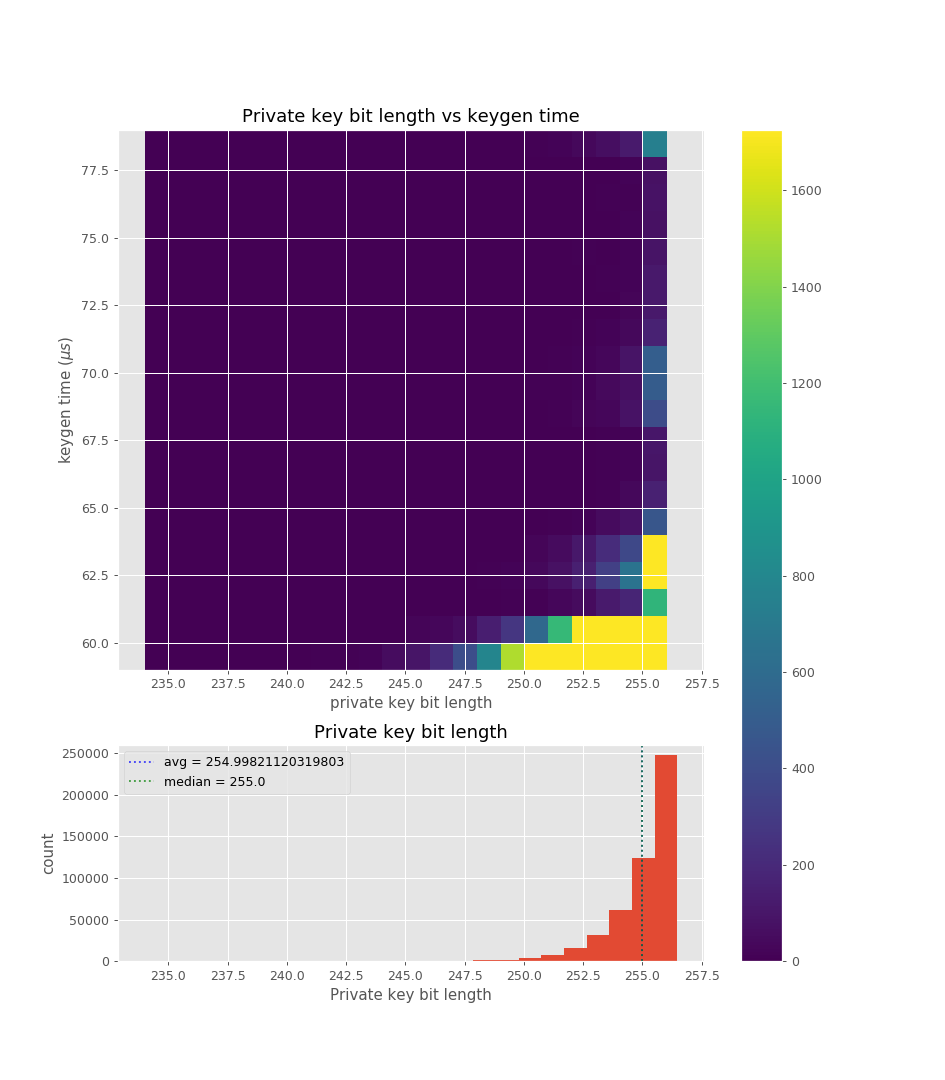

/home/michal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


In [15]:
fig_bl = plt.figure(figsize=(10.5, 12), dpi=90)
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1])
axe_bl_heat = fig_bl.add_subplot(gs[0], title="Private key bit length vs keygen time")
axe_bl_hist = fig_bl.add_subplot(gs[1], sharex=axe_bl_heat, title="Private key bit length")

bl_data = np.array(list(map(lambda x: x.bit_length(), data_trimmed["priv"])), dtype=np.dtype("u2"))

h, xe, ye = np.histogram2d(bl_data, data_trimmed["gen_time"], bins=[max(bl_data) - min(bl_data), hist_size_gen_time_trim])
im = axe_bl_heat.imshow(h.T, origin="low", cmap=cmap, aspect="auto", extent=[xe[0], xe[-1], ye[0], ye[-1]], norm=norm)
axe_bl_heat.set_xlabel("private key bit length")
axe_bl_heat.set_ylabel("keygen time ({})".format(gen_disp_unit))

plot_hist(axe_bl_hist, bl_data, "Private key bit length", log_scale, align="right")

fig_priv_hist.tight_layout()
fig_priv_hist.colorbar(im, ax=[axe_bl_heat, axe_bl_hist])

del bl_data

### Private key bit length histogram given time
Interactively shows the histogram of private key bit length given a selected time range centered around `center` of width `width`. Ideally, the means of these conditional distributions are equal, while the variances can vary.

<IPython.core.display.Javascript object>


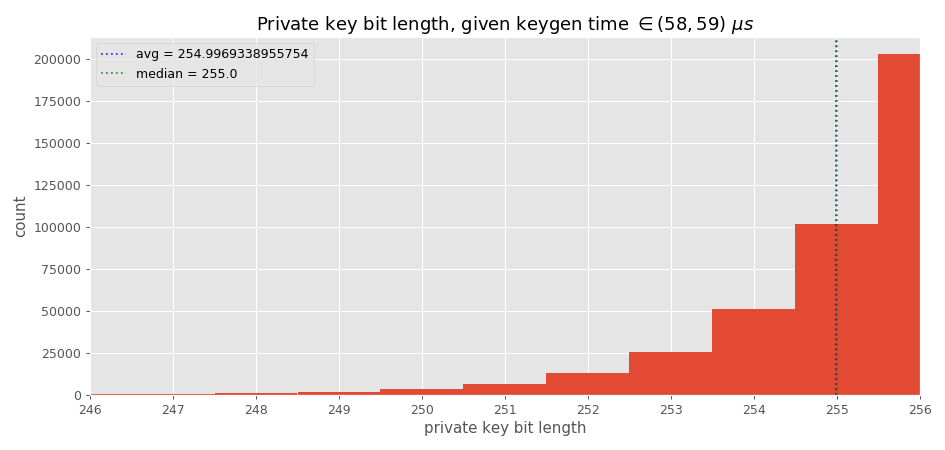

interactive(children=(IntSlider(value=59, continuous_update=False, description='center $\\mu s$', max=79, min=…

In [16]:
fig_bl_time = plt.figure(figsize=(10.5, 5), dpi=90)
axe_bl_time = fig_bl_time.add_subplot(111)
axe_bl_time.set_autoscalex_on(False)
def f(center, width):
    lower_bnd = center - width/2
    upper_bnd = center + width/2
    values = data_trimmed[np.logical_and(data_trimmed["gen_time"] <= upper_bnd,
                                         data_trimmed["gen_time"] >= lower_bnd)]
    axe_bl_time.clear()
    axe_bl_time.set_title("Private key bit length, given keygen time $\in ({}, {})$ {}".format(int(lower_bnd), int(upper_bnd), gen_disp_unit))
    bl_data = np.array(list(map(lambda x: x.bit_length(), values["priv"])), dtype=np.dtype("u2"))
    plot_hist(axe_bl_time, bl_data, "private key bit length", bins=11, range=(bit_size-10, bit_size+1), align="left")
    axe_bl_time.set_xlim((bit_size-10, bit_size))
    fig_bl_time.tight_layout()

center_w = widgets.IntSlider(min=min(data_trimmed["gen_time"]),
                             max=max(data_trimmed["gen_time"]),
                             step=1,
                             value=description_gen_trim.mean,
                             continuous_update=False,
                             description="center {}".format(gen_disp_unit))
width_w = widgets.IntSlider(min=1, max=100, continuous_update=False,
                             description="width {}".format(gen_disp_unit))
w = interactive(f, center=center_w,
                width=width_w)
display(w)

## Validation
Perform some tests on the produced data and compare to expected results.

This requires some information about the used curve, enter it below.

In [18]:
p_str = input("The prime specifying the finite field:")
p = int(p_str, 16) if p_str.startswith("0x") else int(p_str)

The prime specifying the finite field:0xffffffff00000001000000000000000000000000ffffffffffffffffffffffff


In [20]:
r_str = input("The order of the curve:")
r = int(r_str, 16) if r_str.startswith("0x") else int(r_str)

The order of the curve:0xffffffff00000000ffffffffffffffffbce6faada7179e84f3b9cac2fc632551


All of the following tests should pass (e.g. be true), given a large enough sample:

In [21]:
max_priv = max(data["priv"])

print("Private keys are smaller than order:\t\t\t" + str(max_priv < r))
print("Private keys are larger than prime(if order > prime):\t" + str(r <= p or max_priv > p))
print("Private keys reach full bit length of order:\t\t" + str(max_priv.bit_length() == r.bit_length()))

Private keys are smaller than order:			True
Private keys are larger than prime(if order > prime):	True
Private keys reach full bit length of order:		True


In [22]:
print("Private key bit length (min, max):" + str(min(data["priv"]).bit_length()) + ", " + str(max(data["priv"]).bit_length()))

Private key bit length (min, max):234, 256
